# Recurrent neural net example

This notebook visualizes the usage of Vanilla RNN implemented in utorch. It is based on the [PyTorch tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html), in the sense that it uses the same dataset.

The goal of this exercise is to build a character-level model. That kind of model processes one char at a time. Within this notebook, we implemented a model which unrolls the vanilla recurrent neural network.

Before we train the model we checked if it can process a single sequence, generate the correct computational graph.  

Finally, we make a couple of predictions to be sure that the model was trained correctly. The final plot shows that the model can correctly predict the country.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import gc
from random import sample

In [2]:
import utorch
import utorch.nets as nets
import utorch.simplegrad as sg

In [3]:
import unicodedata
import string
import glob
from pathlib import Path

In [4]:
all_letters = string.ascii_letters
n_letters = len(all_letters)


In [5]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [6]:
raw_data = {}

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in glob.glob('data/names/*.txt'):
    category = Path(filename).stem
    lines = readLines(filename)
    raw_data[category] = lines    

In [7]:
def convert_raw_data(raw_data):
    data_x = []
    data_y = []
    mapping_value_country = {}
    language_it = 0
    for language, lines in raw_data.items():
        if len(lines) > 1000:
            lines = sample(lines,1000)
        
        if len(lines)<200:
            continue
        
        name_tensor = [line_to_tensor(line) for line in lines]
        data_x.append(name_tensor)
        data_y.append([language_it]*len(name_tensor))
        mapping_value_country[language_it] = language
        language_it +=1
    return np.concatenate(data_x), np.concatenate(data_y), mapping_value_country


In [8]:
def letter_to_index(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = np.zeros((1, n_letters),dtype=int)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

max_len = lambda x : max(map(len, x))
max_line_size = 10# max([max_len(names) for names in raw_data.values()])

# Turn a line into a <line_length x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = np.zeros((max_line_size, n_letters), dtype=int)
    for letter_it, letter in enumerate(line):
        if letter_it >= max_line_size:
            break;
        tensor[letter_it][letter_to_index(letter)] = 1
    return tensor

In [9]:
x, y, mapping = convert_raw_data(raw_data)

In [10]:
def shuffle_in_union(a,b):

    assert len(a)==len(b)
    c = np.arange(len(a))
    np.random.shuffle(c)

    return a[c],b[c]

In [11]:
x, y =  shuffle_in_union(x,y)

In [12]:
x.shape

(7518, 10, 52)

In [13]:
data_loader = nets.utils.DataLoader(x, y, batch_size=64)

In [14]:
class TanhLayer(nets.Model):
    def __init__(self):
        self.activation = sg.Variable.tanh
    def forward(self, x, *args, **kwargs):
        if not isinstance(x, sg.Variable):
            x = sg.Variable(x)
        return self.activation(x)


class NameRNN(nets.Model):
    def __init__(self, input_size, hidden_size, output_size ):
        self.hidden_size = hidden_size
        self.rnn = nets.Layers.RNNCell(input_size, hidden_size, activation=TanhLayer())
        self.output = nets.LinearLayer(hidden_size, output_size, name="output")
        
        self.output.value = np.random.uniform(0, np.sqrt(2/(hidden_size+output_size)), size=(hidden_size, output_size))
    def forward(self, x):
        """
        This function implements RNN unroll and the idea of many-to-one NN. 
        TODO: enhance this description
        """
        batch_size = x.shape()[0]
        hidden = self.rnn.init_state(batch_size)
        if debug:
            print(f'hidden0 {hidden},\n shape {hidden.shape()}')
        x = self._time_first(x)
        max_iteration =  x.shape()[0]
        for word_it in range(max_iteration):
            x_i = sg.Variable(x.value[word_it])
            hidden = self.rnn(x_i, hidden)
            if debug:
                print(f'hidden {word_it+1}: {hidden}')

        out = self.output(hidden)
        del hidden
        return out    
    
    def _time_first(self, x):
        """
        This function changes order axis from [Batch,n_letters, n_chars] -> [n_letters, batch, n_chars]
        This is use a small hack since sg.transpose does not support tuple params. Will be fixed soon. 
        """
        return sg.Variable(np.transpose(x.value,(1,0,2)))
                

        

In [15]:
## hoooray network can process the input tensor :D 

## One forward +  backward pass to see if the model can process the data 

In [16]:
debug = False
name_model = NameRNN(n_letters, 64, np.max(y))
optim = nets.Adam(name_model,1e-3)
criterion = nets.CrossEntropyWithLogitsLoss( np.max(y), reduce=sg.Variable.mean)
run_hist = {"loss": []}


In [17]:
inputs, labels = data_loader.__next__()
outputs = name_model(inputs)
loss = criterion(outputs,  labels-1)


In [18]:
name_model.rnn.weight_hidden_hidden

Node 0x7ff43199fc88, name weight hidden hidden,
 value [[-0.05468317 -0.09887563  0.04019881 ... -0.08296119  0.28985823
   0.24324038]
 [-0.18454275 -0.13519948  0.12498661 ... -0.02499208 -0.26345614
   0.22506838]
 [ 0.25881181 -0.11067633 -0.08007748 ... -0.02617144  0.03996429
   0.3134277 ]
 ...
 [ 0.06301452  0.08821387  0.2606877  ...  0.06225814  0.01145757
   0.08180299]
 [ 0.09636663 -0.02623424  0.12391816 ... -0.06299431  0.13423986
  -0.06003017]
 [-0.06893469 -0.05232944  0.04026135 ... -0.35333637  0.12673863
   0.06793224]],
 fun None, 
 grad 0 
 *****************

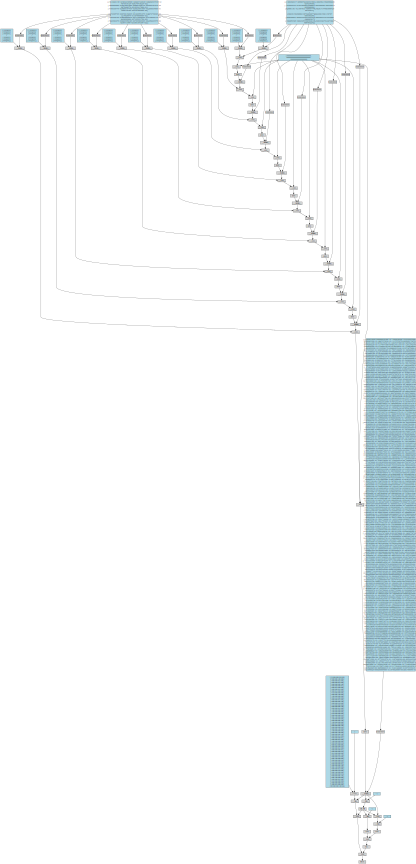

In [19]:
sg.utils.draw_graph(loss)


In [20]:
loss.backward()


In [21]:
optim.zero_grad()

## Train the model 

In [23]:

def train_model(model, criterion, optimizer, run_hist, data_loader, num_epochs=100):
    for epoch in range(num_epochs):
        for iteration, batch in enumerate(data_loader):
            inputs, labels = batch
            outputs = model(inputs)
            loss = criterion(outputs,  labels-1)
            sg.utils.draw_graph(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.update_model()
           

            if iteration % 100 == 0:
                run_hist["loss"].append(loss.value)
                print(f'labels {np.unique(labels.value)}')
                print("epoch {}/{},  it  {}/{}, loss {} ".format(epoch, num_epochs,
                                                             iteration, len(data_loader),
                                                             loss.value))

            #del inputs, labels, loss
            #gc.collect()


In [24]:
mapping

{0: 'Spanish',
 1: 'Japanese',
 2: 'Dutch',
 3: 'Greek',
 4: 'Arabic',
 5: 'French',
 6: 'Chinese',
 7: 'Italian',
 8: 'Irish',
 9: 'English',
 10: 'Russian',
 11: 'German',
 12: 'Czech'}

In [ ]:
debug = False
name_model = NameRNN(n_letters, 64, np.max(y))
optim = nets.Adam(name_model,1e-3)
criterion = nets.CrossEntropyWithLogitsLoss( np.max(y), reduce=sg.Variable.mean)
run_hist = {"loss": []}
train_model(name_model, criterion, optim, run_hist, data_loader, num_epochs=400)

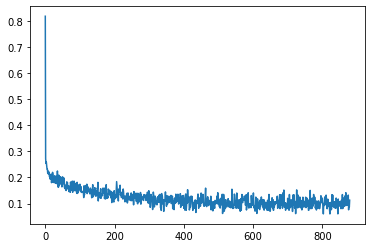

In [37]:
plt.plot(run_hist["loss"]);

In [72]:
def make_prediction(name, model=name_model, with_mapping=False):
    def single_input_to_tensor(line):
        tensor = np.zeros((1,max_line_size, n_letters), dtype=int)
        for letter_it, letter in enumerate(line):
            if letter_it >= max_line_size:
                break;

            tensor[0][letter_it][letter_to_index(letter)] = 1

        return sg.Variable(tensor)
    def softmaxv2(x):
        """Compute softmax values for each sets of scores in x."""

        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    model_input = single_input_to_tensor(name)
    
    out = model(model_input)
    #print(out)
    probas =  softmaxv2(out.value)
    if not with_mapping:
        return np.argmax(probas)+1,np.max(probas)
    return mapping[(np.argmax(probas)+1)],np.max(probas), name


In [73]:
debug=False

In [81]:
make_prediction("Zawadzka", with_mapping=True)

('Czech', 0.9980128099347484, 'Zawadzka')

In [75]:
make_prediction("Xiong", with_mapping=True)

('Chinese', 0.9988854216302366, 'Xiong')

In [76]:
from functools import partial

In [77]:
list(map(partial(make_prediction, with_mapping=True), raw_data["Japanese"]))

[('Italian', 0.48298341586939214, 'Abe'),
 ('Japanese', 0.9626240733823083, 'Abukara'),
 ('Italian', 0.6115985146849988, 'Adachi'),
 ('Japanese', 0.40812030722232456, 'Aida'),
 ('Japanese', 0.9314349075511976, 'Aihara'),
 ('Japanese', 0.9958386849680252, 'Aizawa'),
 ('Russian', 0.7753722233517799, 'Ajibana'),
 ('Japanese', 0.987848734444039, 'Akaike'),
 ('Japanese', 0.9707901359719522, 'Akamatsu'),
 ('Japanese', 0.99608502275969, 'Akatsuka'),
 ('Japanese', 0.823752122362372, 'Akechi'),
 ('Japanese', 0.9942897572585895, 'Akera'),
 ('Japanese', 0.9660232330206804, 'Akimoto'),
 ('Japanese', 0.9995352022013181, 'Akita'),
 ('Japanese', 0.9999020663653313, 'Akiyama'),
 ('Japanese', 0.9999059954024595, 'Akutagawa'),
 ('Japanese', 0.9856555511102988, 'Amagawa'),
 ('Russian', 0.3997544406815024, 'Amaya'),
 ('Arabic', 0.7393901926681473, 'Amori'),
 ('Japanese', 0.9925263458997156, 'Anami'),
 ('Arabic', 0.7410267273895109, 'Ando'),
 ('Czech', 0.43140552441938596, 'Anzai'),
 ('Japanese', 0.9227217

In [43]:
predictions = np.zeros((13, 13),dtype=int)
for language_it, language in mapping.items():
    for example in raw_data[language]:
        predictions[language_it][make_prediction(example)[0]] += 1

In [47]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


dict_values(['Spanish', 'Japanese', 'Dutch', 'Greek', 'Arabic', 'French', 'Chinese', 'Italian', 'Irish', 'English', 'Russian', 'German', 'Czech'])

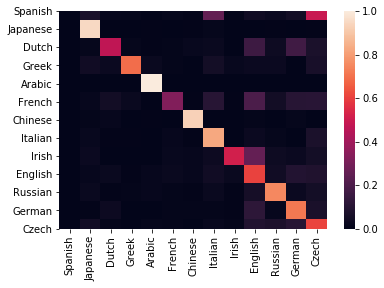

In [52]:
sum_of_rows = predictions.sum(axis=1)
epsilon = 1e-10
normalized_array = predictions / (sum_of_rows[:, np.newaxis] +epsilon) 

sn.heatmap(normalized_array,xticklabels=mapping.values(), yticklabels=mapping.values(),  annot_kws={"size": 20});
